In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)


In [3]:
data = pd.read_csv('train.csv',index_col = 0)
data.head()


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
data.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [5]:
data.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [6]:
data.Response.value_counts()/len(data.Response)*100

0    87.743664
1    12.256336
Name: Response, dtype: float64

C:\Users\91988\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Response')

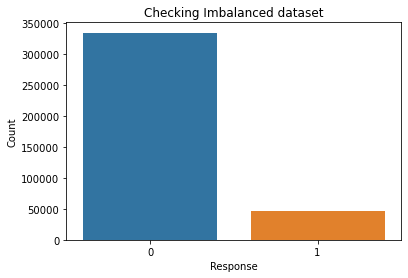

In [7]:
sns.countplot(data['Response'])
plt.title('Checking Imbalanced dataset')
plt.ylabel('Count')
plt.xlabel('Response')

**This is clearly an imbalanced  dataset**

## Seperating numerical and categorical features

In [8]:
numerical_cols = [col for col in data.columns if data[col].dtypes != 'O']
numerical_cols

['Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response']

In [9]:
categorical_cols = [col for col in data.columns if data[col].dtypes == 'O']
categorical_cols

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [10]:
for i in numerical_cols:
    print(len(data[i].unique()))

66
2
53
2
48838
155
290
2


In [11]:
continuous_numerical_cols = [col for col in numerical_cols if len(data[col].unique())>25]
continuous_numerical_cols.remove('Region_Code')
continuous_numerical_cols

['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

In [12]:
discrete_numerical_cols = [col for col in numerical_cols if col not in continuous_numerical_cols]
discrete_numerical_cols.remove('Response')
discrete_numerical_cols


['Driving_License', 'Region_Code', 'Previously_Insured']

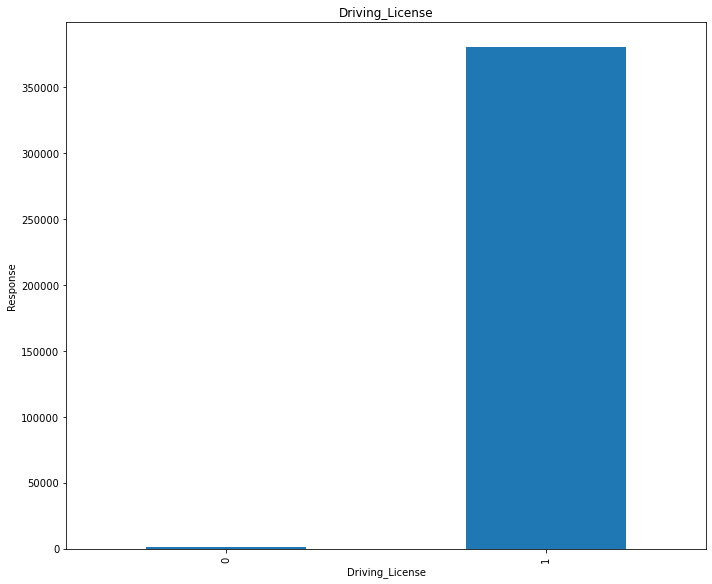

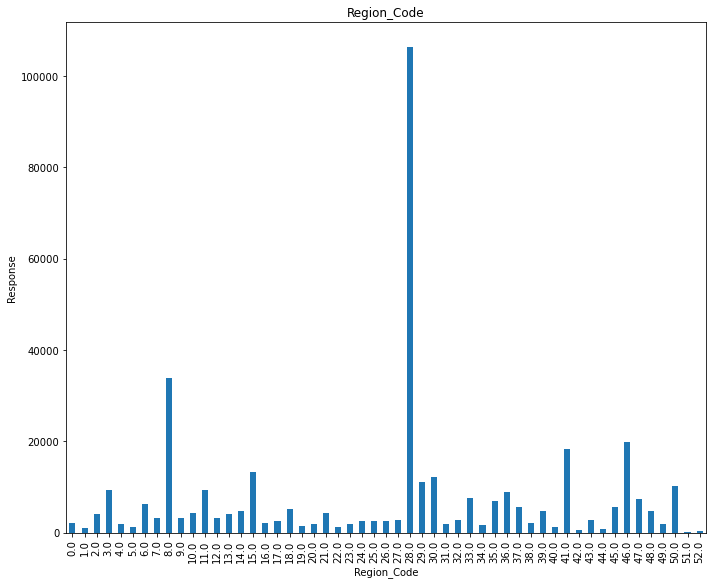

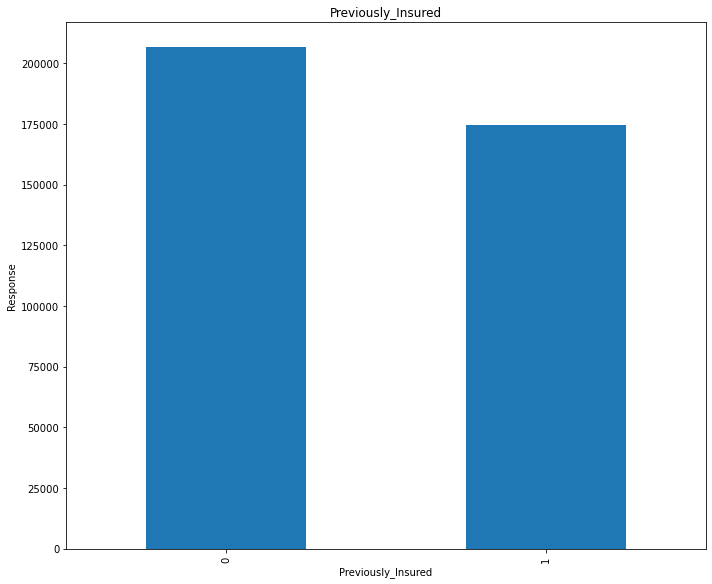

In [13]:
for feature in discrete_numerical_cols:
    plt.figure(figsize=(10,8))
    data1 = data.copy()
    data1.groupby(feature)['Response'].count().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Response')
    plt.tight_layout()
    plt.title(feature)
    plt.show()

This is biased for the Driving_License feature

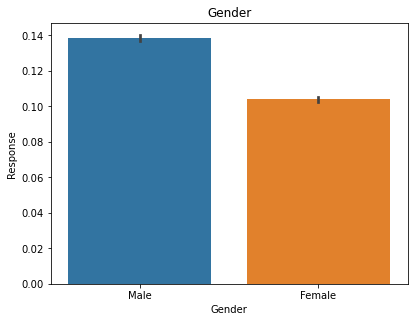

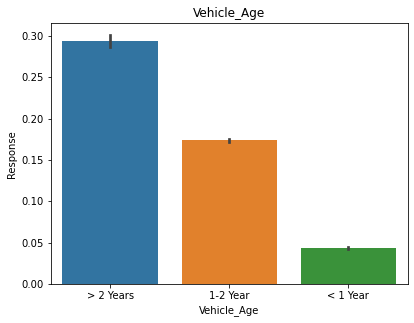

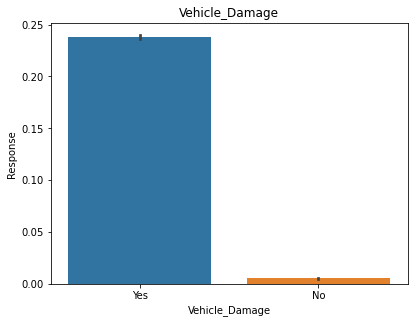

In [14]:
for col in categorical_cols:
    data2 = data.copy()
    plt.figure(figsize=(6.4,4.8))
    sns.barplot(x=col,y='Response',data=data2)
    plt.xlabel(col)
    plt.ylabel('Response')
    plt.title(col)
    plt.show()

Biased for Vehicle_damage feature too...


**For Vehicle_Age we will perform LabelEncoding and for rest of the cat. features we will perform One Hot Encoding**

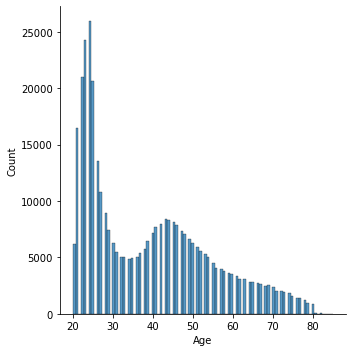

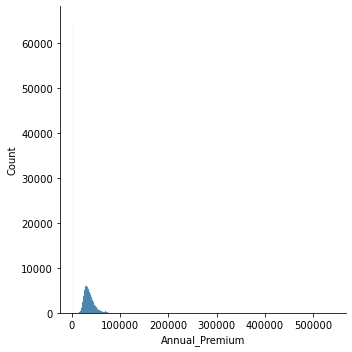

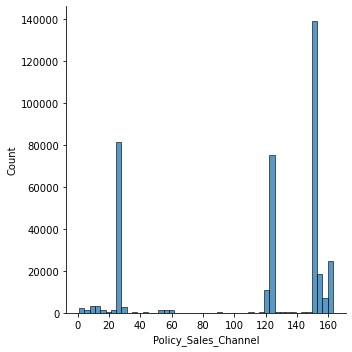

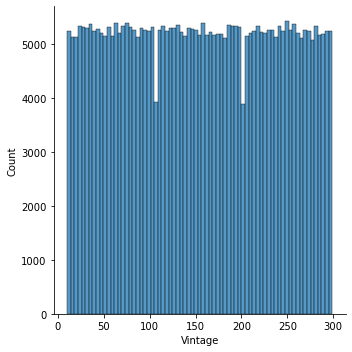

In [15]:
for col in continuous_numerical_cols:
    data3 = data.copy()
    plt.rcParams['figure.figsize']=[6.4,4.8]
    sns.displot(data3[col])
    plt.show()

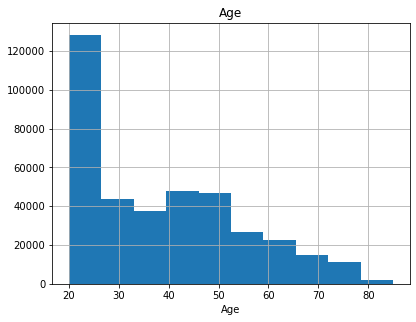

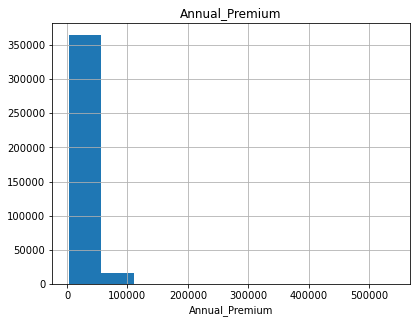

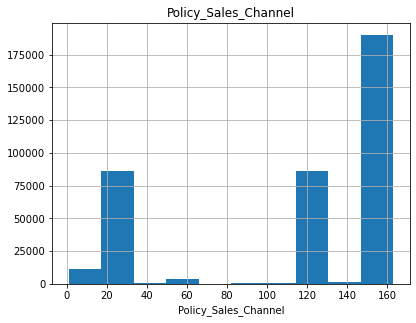

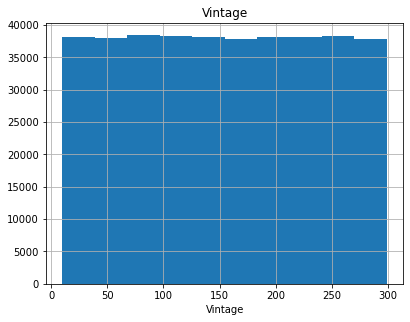

In [16]:
for col in continuous_numerical_cols:
    data4 = data.copy()
    plt.rcParams['figure.figsize']=(6.4,4.8)
    data4[col].hist(bins=10)
    plt.xlabel(col)
    
    plt.title(col)
    plt.show()

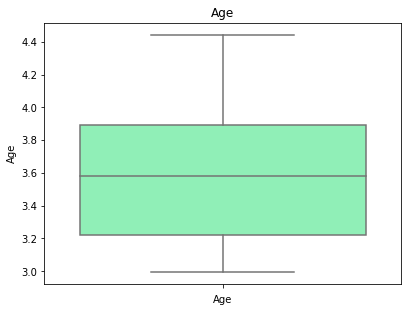

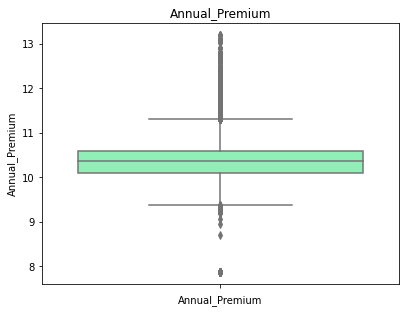

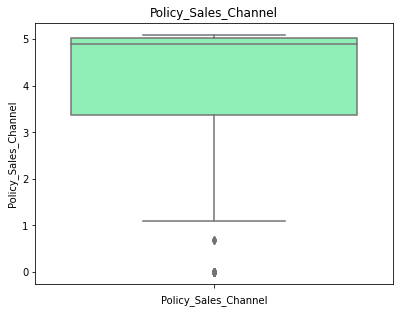

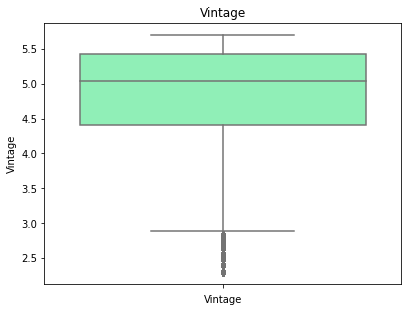

In [17]:
for col in continuous_numerical_cols:
    data5 = data.copy()
    if 0  in data5[col]:
        pass
    else:
        data5[col] = np.log(data[col])
        sns.boxplot(y =data5[col],orient='v',palette='rainbow')
        plt.xlabel(col)
        plt.title(col)
        plt.show()

The data has outliers especially a lot in Annual Premium and Vintage

<AxesSubplot:>

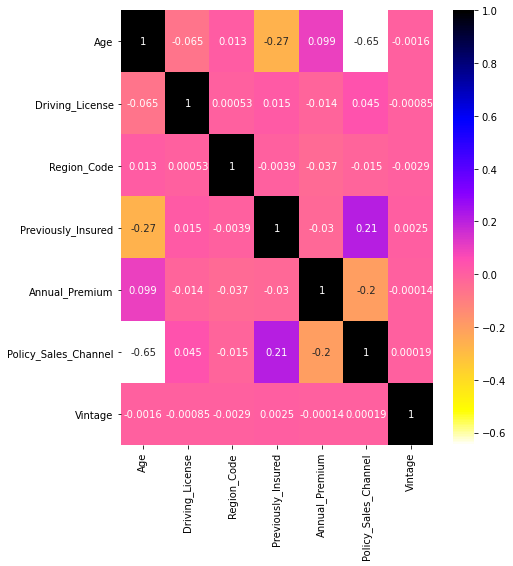

In [18]:
plt.figure(figsize=(7,8))
sns.heatmap(data.drop('Response',axis=1).corr('spearman'),annot=True,cmap=plt.cm.gnuplot2_r)

There is not much correlation and we can take all the features

Let's see how many features are correlated by setting a threshold

In [19]:
def correlation(df,threshold):
    data = df.copy()
    corr_columns = set()
    corr = data.corr('spearman')
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i,j])>threshold:
                corr_columns.add(corr.columns[i])
            
    return corr_columns

In [20]:
correlation(data.copy(),0.85)

set()

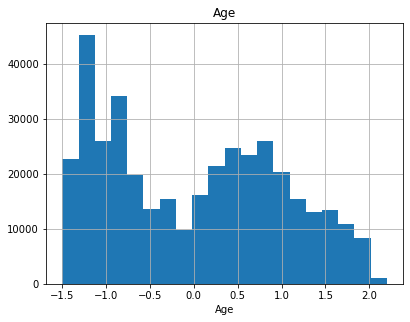

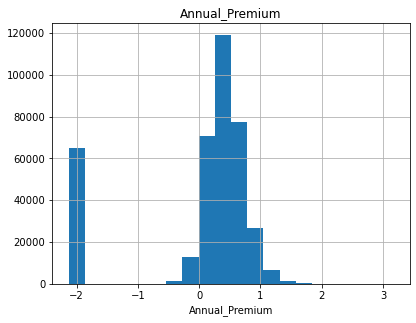

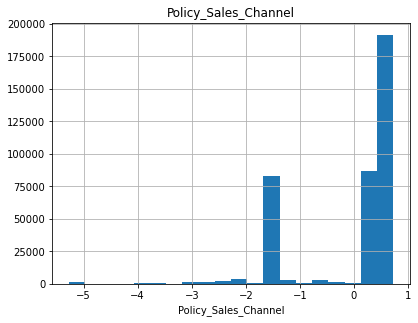

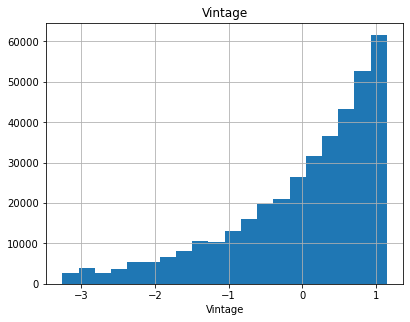

In [21]:
from sklearn.preprocessing import StandardScaler
data6 = data.copy()
scalar = StandardScaler()
data6[continuous_numerical_cols] = np.log(data6[continuous_numerical_cols]) 
data6[continuous_numerical_cols] = scalar.fit_transform(data6[continuous_numerical_cols])

for col in continuous_numerical_cols:
    
    if 0 in data6[col].unique():
        pass
    else:
        
        data6[col].hist(bins=20)
        plt.xlabel(col)
        plt.title(col)
        plt.show()

C:\Users\91988\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


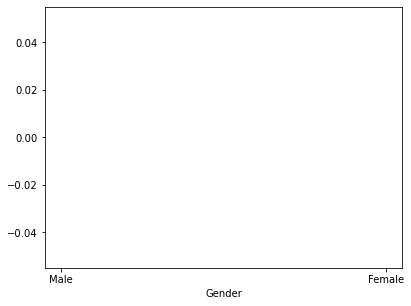

C:\Users\91988\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


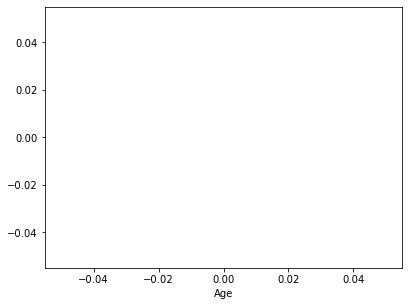

C:\Users\91988\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


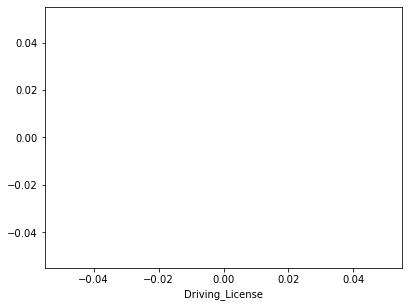

C:\Users\91988\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


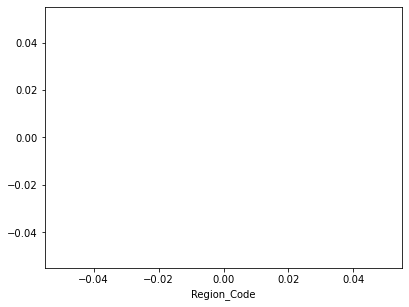

C:\Users\91988\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


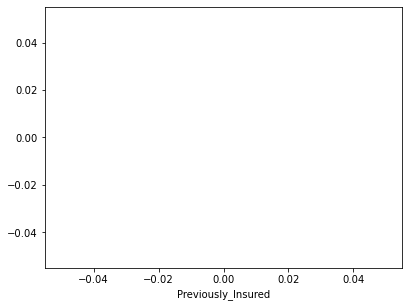

C:\Users\91988\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


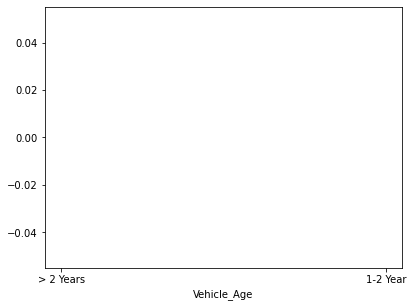

C:\Users\91988\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


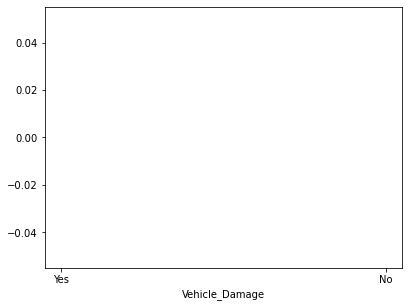

C:\Users\91988\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


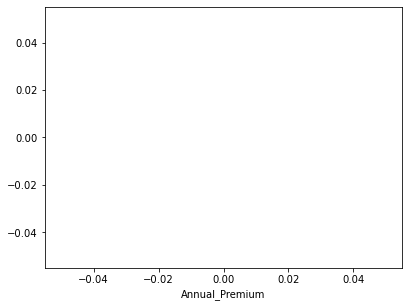

C:\Users\91988\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


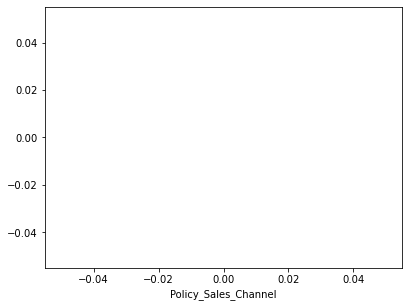

C:\Users\91988\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


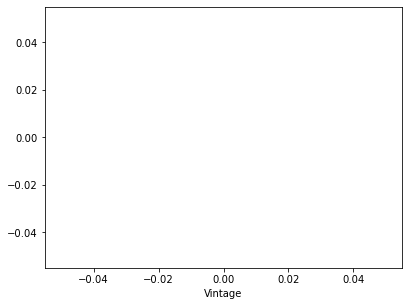

C:\Users\91988\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


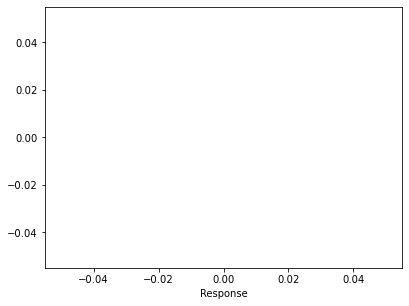

In [23]:
for i in data.columns:
    sns.scatterplot()
    plt.show()